In [1]:
%config Completer.use_jedi = False
from numba import jit
#import datatable as dt
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
from matplotlib import rc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d.art3d import Line3DCollection
%matplotlib inline

In [2]:
def bus_load_mapping(station, xx, yy):
    [xxx, yyy] = list(df_bus_master[df_bus_master['버스정류장']==station].iloc[(abs(xx-df_bus_master[df_bus_master['버스정류장']
        ==station]['X좌표'].values)+abs(yy-df_bus_master[df_bus_master['버스정류장']==station]['Y좌표'].values)).argmin()][7:9].values)
    if abs(xx-xxx)>0.03 or abs(yy-yyy)>0.03:
        t.append(station)
    return [xxx, yyy]

def metro_load_mapping(station, xx, yy):
    [xxx, yyy] = list(df_metro_master[df_metro_master['역명1']==station].iloc[(abs(xx-df_metro_master[df_metro_master['역명1']
        ==station]['좌표_X'].values)+abs(yy-df_metro_master[df_metro_master['역명1']==station]['좌표_Y'].values)).argmin()][7:9].values)
    if abs(xx-xxx)>0.03 or abs(yy-yyy)>0.03:
        t.append(station)
    return [xxx, yyy]    

def dijsktra(graph, initial, end):
    shortest_paths = {initial: (None, 0, '')}
    current_node = initial
    visited = set()
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1] 
        current_line = shortest_paths[current_node][2]        
        for next_node in destinations:
            flag = False
            for i in current_line:
                if i in find_line(current_node, next_node):
                    flag = True
            if flag:
                weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            else:
                weight = graph.weights[(current_node, next_node)] + weight_to_current_node + 5
                    
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight, find_line(current_node, next_node))
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight, find_line(current_node, next_node))
                    
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return "Route Not Possible"
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
        
    destination_node = current_node
    path = []
    while destination_node is not None:
        path.append(destination_node)
        next_node = shortest_paths[destination_node][0]
        destination_node = next_node 
    path = path[::-1]
    return path

def find_line(c, n):
    line = []
    for i in subway_line:
        if len(subway_line[i])<=5:
            for j in subway_line[i]:
                if c in j and n in j:
                    if abs(j.index(c) - j.index(n))<=1:
                        line.append(i)
        else:
            if c in subway_line[i] and n in subway_line[i]:
                    if abs(subway_line[i].index(c) - subway_line[i].index(n))<=1:
                        line.append(i)
    return line

def split_underline(dic):
    start.clear()
    end.clear()
    for i in dic.keys():
        buf = i.split('_')
        start.append(buf[0])
        end.append(buf[1])
        
def bus_stop_name(station):
    buf = station.find('.')
    if station.find('(')==0:
        station = station.split(')')[1]
    if buf>1 or buf==-1:
        station = station.split('.')[0].split('·')[0].split('(')[0]
    else:
        station = station.split('(')[0]
    return station

def drop_overlap(df):
    buf = []
    for i,j in enumerate(df.values):
        if j[0]==j[1]:
            buf.append(i)
    buf = list(set(buf))
    df = df.drop(buf)
    df = df.reset_index(drop=True)
    return df


In [3]:
df = pd.read_csv('dataset\metro_bus/N_TRP_210101.csv')
df_bus_master = pd.read_csv('dataset\metro_bus\서울버스정류장_Master_202210.csv', encoding='cp949')
df_metro_master = pd.read_csv('dataset\metro_bus\지하철역사정보_Master_2022_10.csv', encoding='cp949')
df_bus_master = df_bus_master.loc[:, ['버스정류장ID', '버스정류장명']]
df_metro_master = df_metro_master.loc[:, ['역ID', '역명']]
df_bus_path = pd.read_csv('dataset\metro_bus\서울버스노선정보_Master_v2 - 수정본.csv', encoding='cp949')

C:\Users\user\AppData\Local\Temp\ipykernel_13276\3886498431.py:1: DtypeWarning: Columns (9,10,15,16,17,18,19,23,24,26,27,31,32,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset\metro_bus/N_TRP_210101.csv')


In [4]:
df = df.drop(df[df['최초승차일시']=='~'].index)
df['최초승차일시'] = df['최초승차일시'].astype(str)
df = df.sort_values('최초승차일시')
df = df.reset_index(drop=True)

In [61]:
print('새벽(04:00~7:00) :',df[df['최초승차일시']=='20210101040000'].index[0], '~', df[df['최초승차일시']=='20210101070000'].index[0])
print('출근시간(7:00~9:00) :',df[df['최초승차일시']=='20210101070000'].index[0], '~', df[df['최초승차일시']=='20210101090000'].index[0])
print('오전(9:00~12:00) :',df[df['최초승차일시']=='20210101090000'].index[0], '~', df[df['최초승차일시']=='20210101120000'].index[0])
print('오후(12:00~17:00) :',df[df['최초승차일시']=='20210101120000'].index[0], '~', df[df['최초승차일시']=='20210101170000'].index[0])
print('퇴근시간(17:00~19:00) :',df[df['최초승차일시']=='20210101170000'].index[0], '~', df[df['최초승차일시']=='20210101190000'].index[0])
print('저녁~야간(19:00~24:00) :',df[df['최초승차일시']=='20210101190000'].index[0], '~', df[df['최초승차일시']=='20210102000000'].index[0])
print('야간~새벽(24:00~03:50) :',df[df['최초승차일시']=='20210102000000'].index[0], '~', len(df))

새벽(04:00~7:00) : 0 ~ 152772
출근시간(7:00~9:00) : 152772 ~ 389808
오전(9:00~12:00) : 389808 ~ 875420
오후(12:00~17:00) : 875420 ~ 2092242
퇴근시간(17:00~19:00) : 2092242 ~ 2564003
저녁~야간(19:00~24:00) : 2564003 ~ 3217512
야간~새벽(24:00~03:50) : 3217512 ~ 3224846


In [5]:
bus_id = [16, 24, 32, 40, 48]
trans_code_list = [15, 23, 31, 39, 47]
ride_list = [20,28,36,44,52]
bus_list = [62, 66, 70, 74, 78]
metro_list = [64, 68, 72, 76, 80]

entire_num = len(df)

#df_c = df.copy()     # 하루 전체 데이터 사용할거면 이 줄 주석 제거 후 아래줄 주석
sub_num = 100000 ;df_c = df[:sub_num]   # 사용할 레코드 수 지정

for i in range(1, 6):
    df_c['교통수단코드'+str(i)] = df_c['교통수단코드'+str(i)].replace('~', 0)
    df_c['교통수단코드'+str(i)] = df_c['교통수단코드'+str(i)].astype(int)
df_c = df_c.reset_index(drop=True)

buf = []
for i,j in enumerate(df_c.values):
    for k in range(j[2]+1):        
        if j[ride_list[k]]==j[ride_list[k]+1]:
            buf.append(i)
buf = list(set(buf))
df_c = df_c.drop(buf)
df_c = df_c.reset_index(drop=True)

c:\users\ccccc\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


# 암호화된 역(정류장)ID 마스터데이터로 복호화

In [6]:
bus_master_dict = {'~':'~'}
subway_master_dict = {'~':'~'}
t = 0
for i in df_bus_master.values:
    bus_master_dict[i[0]] = i[1]
for i in df_metro_master.values:
    subway_master_dict[i[0]] = i[1]

df_c = pd.merge(df_c,df_bus_master, how='left', left_on='최초승차역ID', right_on='버스정류장ID')
df_c = df_c.drop('버스정류장ID', axis=1)
df_c = df_c.rename(columns={'버스정류장명':'최초승차역ID_bus'})
df_c = pd.merge(df_c,df_metro_master, how='left', left_on='최초승차역ID', right_on='역ID')
df_c = df_c.drop('역ID', axis=1)
df_c = df_c.rename(columns={'역명':'최초승차역ID_subway'})

for n in tqdm(range(1, 6)):
    df_c = pd.merge(df_c,df_bus_master, how='left', left_on='승차역ID'+str(n), right_on='버스정류장ID')
    df_c = df_c.drop('버스정류장ID', axis=1)
    df_c = df_c.rename(columns={'버스정류장명':'승차역ID'+str(n)+'_bus'})
    df_c = pd.merge(df_c,df_bus_master, how='left', left_on='하차역ID'+str(n), right_on='버스정류장ID')
    df_c = df_c.drop('버스정류장ID', axis=1)
    df_c = df_c.rename(columns={'버스정류장명':'하차역ID'+str(n)+'_bus'})
    df_c = pd.merge(df_c,df_metro_master, how='left', left_on='승차역ID'+str(n), right_on='역ID')
    df_c = df_c.drop('역ID', axis=1)
    df_c = df_c.rename(columns={'역명':'승차역ID'+str(n)+'_subway'})
    df_c = pd.merge(df_c,df_metro_master, how='left', left_on='하차역ID'+str(n), right_on='역ID')
    df_c = df_c.drop('역ID', axis=1)
    df_c = df_c.rename(columns={'역명':'하차역ID'+str(n)+'_subway'})
    

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.43s/it]


In [7]:
df_bus_master = pd.read_csv('dataset\metro_bus\서울버스정류장_Master_202210.csv', encoding='cp949')
df_metro_master = pd.read_csv('dataset\metro_bus\지하철역사정보_Master_2022_10.csv', encoding='cp949')
df_bus_master = df_bus_master.drop(df_bus_master[df_bus_master['X좌표']=='~'].index)
df_bus_master['X좌표'] = df_bus_master['X좌표'].astype(float)
df_bus_master['Y좌표'] = df_bus_master['Y좌표'].astype(float)
df_bus_master = df_bus_master.reset_index(drop=True)

# '(', '.', '·' 앞글자까지 정류장명, 역명 수정

In [8]:
buf = list(df_bus_master['버스정류장명'].values)
for i in range(len(buf)):
    if '.' in buf[i] or '(' in buf[i] or '·' in buf[i]:
        buf[i] = bus_stop_name(buf[i])
df_bus_master = pd.concat([df_bus_master, pd.DataFrame(buf)], axis=1)
df_bus_master = df_bus_master.rename(columns={0:'버스정류장'})

buf = list(df_metro_master['역명'].values)
for i in range(len(buf)):
    if '(' in buf[i]:
        buf[i] = buf[i].split('(')[0]
df_metro_master = pd.concat([df_metro_master, pd.DataFrame(buf)], axis=1)
df_metro_master = df_metro_master.rename(columns={0:'역명1'})

# 로카모빌리티(캐시비) 레코드 삭제

In [9]:
lm_idx = []
count = 0
for i in range(1,6):
    lm_idx.extend(df_c[df_c['승차역ID'+str(i)].map(len)==7]['승차역ID'+str(i)].index)
lm_idx = list(set(lm_idx))
df_c = df_c.drop(lm_idx)
df_c = df_c.reset_index(drop=True)

# 경로 빈도수 계산

In [10]:
# 이용자수 많은 10개 노선
# top10 = ['11110017', '11110021', '11110249', '11110010', '11110980', '11110013', '11110035', '11110002', '11110966', '11410002']

In [11]:
bus_path_dic = {}
bm_inter_path_dic = {}
mb_inter_path_dic = {}
t = []
pos = []
b_dic = {}
x, y = 0, 0
for i in tqdm(df_c.values):
    
    for j in range(i[2]+1):
#         if str(i[bus_id[j]]) in top10:
            if i[bus_id[j]] != '~':
                if int(i[bus_id[j]]) <= 20000000:
                    try:
                        path = df_bus_path[df_bus_path['서울버스노선ID']==str(i[bus_id[j]])]['경로'].values[0].split('-')
                    except:
                        continue
                        pass
                    if i[trans_code_list[j]]<200:
                        try:
                            for k in range(len(path)):
                                path[k] = bus_stop_name(path[k])
                            path=path[path.index(bus_stop_name(i[bus_list[j]])):path.index(bus_stop_name(i[bus_list[j]+1]))+1]
                        except:
                            continue
                            pass
                        
                        
                        
                    for k in range(len(path)):
                        if path[k] not in b_dic.keys():
                            try:
                                x, y = bus_load_mapping(path[k], x, y)
                                b_dic[path[k]] = [x, y]
                            except:
                                pass
                    for n in range(len(t)):
                        for nn in range(len(path)):
                            if path[nn] in b_dic.keys() and path[nn]!=t[n]:
                                x, y = b_dic[path[nn]]
                                break
                        b_dic[t[n]] = bus_load_mapping(t[n], x, y)
                    t = []
                        
                    for k in range(len(path)-1):
                        if path[k] in b_dic.keys() and path[k+1] in b_dic.keys():
                            buf = path[k]+'_'+path[k+1]
                            if buf in bus_path_dic.keys():
                                bus_path_dic[buf] = bus_path_dic[buf]+1
                            else:
                                bus_path_dic[buf] = 1
                                
                                
    for j in range(i[2]):
        try:
#             if df_bus_path[df_bus_path['서울버스노선ID']==str(i[bus_id[j]])]['서울버스노선ID'].values[-1:] in top10:
                if i[trans_code_list[j]]<200 and i[trans_code_list[j+1]]>=200:
                    buf = bus_stop_name(i[bus_list[j]+1])+ '_' + i[metro_list[j+1]].split('(')[0]
                    if buf in bm_inter_path_dic.keys():
                        bm_inter_path_dic[buf] = bm_inter_path_dic[buf] + 1
                    else:
                        bm_inter_path_dic[buf] = 1
                if i[trans_code_list[j]]>=200 and i[trans_code_list[j+1]]<200:
                    buf = i[metro_list[j]+1].split('(')[0]+ '_' + bus_stop_name(i[bus_list[j+1]])
                    if buf in mb_inter_path_dic.keys():
                        mb_inter_path_dic[buf] = mb_inter_path_dic[buf] + 1
                    else:
                        mb_inter_path_dic[buf] = 1            
        except:
            pass
pos.append(b_dic.copy())

100%|███████████████████████████████████████████████████████████████████████████| 67268/67268 [02:22<00:00, 472.08it/s]


# 버스layer intra-edge

In [12]:
start = []
end = []
split_underline(bus_path_dic)
bus_path_df = pd.concat([pd.DataFrame(start), pd.DataFrame(end), pd.DataFrame(bus_path_dic.values())], axis=1)
bus_path_df.columns = ['출발지', '도착지', 'count']

# 버스-지하철 층간 Inter-edge

In [13]:
split_underline(bm_inter_path_dic)
bm_path_df = pd.concat([pd.DataFrame(start), pd.DataFrame(end), pd.DataFrame(bm_inter_path_dic.values())], axis=1)
bm_path_df.columns = ['출발지(버스정류장)', '도착지(역)', 'count']

try:
    split_underline(mb_inter_path_dic)
    mb_path_df = pd.concat([pd.DataFrame(start), pd.DataFrame(end), pd.DataFrame(mb_inter_path_dic.values())], axis=1)
    mb_path_df.columns = ['출발지(역)', '도착지(버스정류장)', 'count']
    mb_path_df
except:
    pass

In [16]:
buf = []
for i in range(len(bm_path_df)):
    if len(df_bus_master[df_bus_master['버스정류장']==bm_path_df.iloc[i].values[0]].index)!=0 and len(df_metro_master[df_metro_master['역명1']==bm_path_df.iloc[i].values[1]].index)!=0:
        buf.append(i)
bm_path_df = bm_path_df.iloc[buf]
buf = []
for i in range(len(mb_path_df)):
    if len(df_bus_master[df_bus_master['버스정류장']==mb_path_df.iloc[i].values[1]].index)!=0 and len(df_metro_master[df_metro_master['역명1']==mb_path_df.iloc[i].values[0]].index)!=0:
        buf.append(i)
mb_path_df = mb_path_df.iloc[buf]

# 지하철역 Intra edge

In [17]:
subway_line = {'1호선':[['소요산', '동두천', '보산', '동두천중앙', '지행', '덕정', '덕계', '양주', '녹양', '가능',
       '의정부', '회룡', '망월사', '도봉산', '도봉', '방학', '창동', '녹천', '월계', '광운대',
       '석계', '신이문', '외대앞', '회기', '청량리', '제기동', '신설동', '동묘앞', '동대문',
       '종로5가', '종로3가', '종각', '시청', '서울역', '남영', '용산', '노량진', '대방', '신길',
       '영등포', '신도림', '구로', '구일', '개봉', '오류동', '온수', '역곡', '소사', '부천',
       '중동', '송내', '부개', '부평', '백운', '동암', '간석', '주안', '도화', '제물포', '도원',
       '동인천', '인천'], ['구로', '독산', '금천구청', '광명'], ['광명','금천구청', '석수', '관악', '안양', '명학', '금정', '군포',
       '당정', '의왕', '성균관대', '화서', '수원', '세류', '병점', '서동탄'], ['서동탄', '병점', '세마', '오산대',
       '오산', '진위', '송탄', '서정리', '평택지제', '평택', '성환', '직산', '두정', '천안',
       '봉명', '쌍용', '아산', '탕정', '배방', '온양온천', '신창']],
        '2호선':[['시청', '을지로입구', '을지로3가', '을지로4가', '동대문역사문화공원', '신당', '상왕십리', '왕십리',
       '한양대', '뚝섬', '성수', '건대입구', '구의', '강변', '잠실나루', '잠실', '잠실새내',
       '종합운동장', '삼성', '선릉', '역삼', '강남', '교대', '서초', '방배', '사당', '낙성대',
       '서울대입구', '봉천', '신림', '신대방', '구로디지털단지', '대림', '신도림', '문래', '영등포구청',
       '당산', '합정', '홍대입구', '신촌', '이대', '아현', '충정로', '시청'], ['신설동', '용두', '신답', '용답', '성수'], 
               ['까치산', '신정네거리', '양천구청', '도림천', '신도림']],
        '3호선':['대화', '주엽', '정발산', '마두', '백석', '대곡', '화정', '원당', '원흥', '삼송', '지축',
       '구파발', '연신내', '불광', '녹번', '홍제', '무악재', '독립문', '경복궁', '안국', '종로3가',
       '을지로3가', '충무로', '동대입구', '약수', '금호', '옥수', '압구정', '신사', '잠원',
       '고속터미널', '교대', '남부터미널', '양재', '매봉', '도곡', '대치', '학여울', '대청', '일원',
       '수서', '가락시장', '경찰병원', '오금'],
        '4호선':['진접', '오남', '별내별가람', '당고개', '상계', '노원', '창동', '쌍문', '수유', '미아',
       '미아사거리', '길음', '성신여대입구', '한성대입구', '혜화', '동대문', '동대문역사문화공원', '충무로',
       '명동', '회현', '서울역', '숙대입구', '삼각지', '신용산', '이촌', '동작', '총신대입구', '사당',
       '남태령', '선바위', '경마공원', '대공원', '과천', '정부과천청사', '인덕원', '평촌', '범계',
       '금정', '산본', '수리산', '대야미', '반월', '상록수', '한대앞', '중앙', '고잔', '초지',
       '안산', '신길온천', '정왕', '오이도'],
        '5호선':[['방화', '개화산', '김포공항', '송정', '마곡', '발산', '우장산', '화곡', '까치산', '신정',
       '목동', '오목교', '양평', '영등포구청', '영등포시장', '신길', '여의도', '여의나루', '마포',
       '공덕', '애오개', '충정로', '서대문', '광화문', '종로3가', '을지로4가', '동대문역사문화공원',
       '청구', '신금호', '행당', '왕십리', '마장', '답십리', '장한평', '군자', '아차산', '광나루',
       '천호', '강동'], ['마천', '거여', '개롱', '오금', '방이', '올림픽공원', '둔촌동', '강동', '길동', '굽은다리',
       '명일', '고덕', '상일동', '강일', '미사', '하남풍산', '하남시청', '하남검단산']],
        '6호선':[['응암', '역촌', '불광', '독바위', '연신내', '구산', '응암'],
           ['응암', '새절', '증산', '디지털미디어시티', '월드컵경기장', '마포구청', '망원', '합정', '상수',
       '광흥창', '대흥', '공덕', '효창공원앞', '삼각지', '녹사평', '이태원', '한강진', '버티고개',
       '약수', '청구', '신당', '동묘앞', '창신', '보문', '안암', '고려대', '월곡', '상월곡',
       '돌곶이', '석계', '태릉입구', '화랑대', '봉화산', '신내']],
        '7호선':['장암', '도봉산', '수락산', '마들', '노원', '중계', '하계', '공릉', '태릉입구', '먹골',
       '중화', '상봉', '면목', '사가정', '용마산', '중곡', '군자', '어린이대공원', '건대입구',
       '뚝섬유원지', '청담', '강남구청', '학동', '논현', '반포', '고속터미널', '내방', '이수', '남성',
       '숭실대입구', '상도', '장승배기', '신대방삼거리', '보라매', '신풍', '대림', '남구로',
       '가산디지털단지', '철산', '광명사거리', '천왕', '온수', '까치울', '부천종합운동장', '춘의',
       '신중동', '부천시청', '상동', '삼산체육관', '굴포천', '부평구청', '산곡', '석남'],
        '8호선':['암사', '천호', '강동구청', '몽촌토성', '잠실', '석촌', '송파', '가락시장', '문정', '장지',
       '복정', '남위례', '산성', '남한산성입구', '단대오거리', '신흥', '수진', '모란'],
        '9호선':['개화', '김포공항', '공항시장', '신방화', '마곡나루', '양천향교', '가양', '증미', '등촌',
       '염창', '신목동', '선유도', '당산', '국회의사당', '여의도', '샛강', '노량진', '노들', '흑석',
       '동작', '구반포', '신반포', '고속터미널', '사평', '신논현', '언주', '선정릉', '삼성중앙',
       '봉은사', '종합운동장', '삼전', '석촌고분', '석촌', '송파나루', '한성백제', '올림픽공원',
       '둔촌오륜', '중앙보훈병원'],
        '경강선':['판교', '이매', '삼동', '경기광주', '초월', '곤지암', '신둔도예촌', '이천', '부발',
       '세종대왕릉', '여주'],
        '경의선':[['가좌', '홍대입구', '서강대', '공덕', '효창공원앞', '용산', '이촌', '서빙고', '한남', '옥수',
       '응봉', '왕십리', '청량리', '회기', '중랑', '상봉', '망우', '양원', '구리', '도농', '양정',
       '덕소', '도심', '팔당', '운길산', '양수', '신원', '국수', '아신', '오빈', '양평.경기도', '원덕',
       '용문', '지평'],['서울역', '신촌', '가좌', '디지털미디어시티', '수색', '화전', '강매', '행신', '능곡', '대곡',
       '곡산', '백마', '풍산', '일산', '탄현', '야당', '운정', '금릉', '금촌', '월롱', '파주',
       '문산', '임진강']],
        '경춘선':[['청량리', '회기', '중랑', '상봉', '망우', '신내', '갈매', '별내', '퇴계원', '사릉', '금곡', '평내호평',
               '천마산', '마석', '대성리', '청평', '상천', '가평', '굴봉산', '백양리', '강촌', '김유정', '남춘천', '춘천'],
              ['광운대', '상봉']],
        '공항철도':['서울역', '공덕', '홍대입구', '디지털미디어시티', '마곡나루', '김포공항', '계양', '검암',
       '청라국제도시', '영종', '운서', '공항화물청사', '인천공항1터미널', '인천공항2터미널'],
        '김포공항철도':['양촌', '구래', '마산', '장기', '운양', '걸포북변', '사우', '풍무', '고촌', '김포공항'],
        '서해선':['소사', '소새울', '시흥대야', '신천', '신현', '시흥시청', '시흥능곡', '달미', '선부', '초지',
       '시우', '원시'],
        '수인분당선':['청량리', '왕십리', '서울숲', '압구정로데오', '강남구청', '선정릉', '선릉', '한티', '도곡',
       '구룡', '개포동', '대모산입구', '수서', '복정', '가천대', '태평', '모란', '야탑', '이매',
       '서현', '수내', '정자', '미금', '오리', '죽전', '보정', '구성', '신갈', '기흥', '상갈',
       '청명', '영통', '망포', '매탄권선', '수원시청', '매교', '수원', '고색', '오목천', '어천',
       '야목', '사리', '한대앞', '중앙', '고잔', '초지', '안산', '신길온천', '정왕', '오이도',
       '달월', '월곶', '소래포구', '인천논현', '호구포', '남동인더스파크', '원인재', '연수', '송도',
       '인하대', '숭의', '신포', '인천'],
        '신림선':['샛강', '대방', '서울지방병무청', '보라매', '보라매공원', '보라매병원', '당곡', '신림', '서원',
       '서울대벤처타운', '관악산'],
        '신분당선':['신사', '논현', '신논현', '강남', '양재', '양재시민의숲', '청계산입구', '판교', '정자', '미금',
       '동천', '수지구청', '성복', '상현', '광교중앙', '광교'],
        '용인경전철':['기흥', '강남대', '지석', '어정', '동백', '초당', '삼가', '시청.용인대', '명지대', '김량장',
       '운동장.송담대', '고진', '보평', '둔전', '전대.에버랜드'],
        '우이신설경전철':['북한산우이', '솔밭공원', '4.19민주묘지', '가오리', '화계', '삼양', '삼양사거리', '솔샘',
       '북한산보국문', '정릉', '성신여대입구', '보문', '신설동'],
        '의정부경전철':['발곡', '회룡', '범골', '경전철의정부', '의정부시청', '흥선', '의정부중앙', '동오', '새말',
       '경기도청북부청사', '효자', '곤제', '어룡', '송산', '탑석'],
        '인천1호선':['계양', '귤현', '박촌', '임학', '계산', '경인교대입구', '작전', '갈산', '부평구청', '부평시장',
       '부평', '동수', '부평삼거리', '간석오거리', '인천시청', '예술회관', '인천터미널', '문학경기장',
       '선학', '신연수', '원인재', '동춘', '동막', '캠퍼스타운', '테크노파크', '지식정보단지',
       '인천대입구', '센트럴파크', '국제업무지구', '송도달빛축제공원'],
        '인천2호선':['검단오류', '왕길', '검단사거리', '마전', '완정', '독정', '검암', '검바위', '아시아드경기장',
       '서구청', '가정', '가정중앙시장', '석남', '서부여성회관', '인천가좌', '가재울', '주안국가산단',
       '주안', '시민공원', '석바위시장', '인천시청', '석천사거리', '모래내시장', '만수', '남동구청',
       '인천대공원', '운연']
}

In [18]:
class Graph():
    def __init__(self):
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node):
        for i in to_node:
            self.edges[from_node].append(i)
            self.weights[(from_node, i)] = 1
            self.weights[(i, from_node)] = 1

# Graph 클래스에 값을 형식에 맞게 넣을수 있도록 전처리

In [19]:
g = {}
buf = []
for n in df_metro_master['역명1'].values:
    if n not in g.keys():
        for i in subway_line.keys():
            if len(subway_line[i])<=5:
                for j in subway_line[i]:
                    if n in j:
                        if j.index(n)!=0:
                            buf.append(j[j.index(n)-1])
                        if j.index(n)!=len(j)-1:
                            buf.append(j[j.index(n)+1])
            else:
                if n in subway_line[i]:
                    if subway_line[i].index(n)!=0:
                        buf.append(subway_line[i][subway_line[i].index(n)-1])
                    if subway_line[i].index(n)!=len(subway_line[i])-1:
                        buf.append(subway_line[i][subway_line[i].index(n)+1])
        g[n] = buf
        buf = []

In [20]:
graph = Graph()
for edge in g:
    graph.add_edge(edge, g[edge])

# dijsktra 계산 후 결과값 = path리스트
# path리스트에 경로상에 가장 적절한 위상정보 추출 및 경로빈도 계산

In [21]:
count = 0
metro_path_dic = {}
metro_list = [64, 68, 72, 76, 80]
m_dic = {}
buf_path = {}
for i in tqdm(df_c.values):
    for j in range(i[2]+1):
        if i[trans_code_list[j]]>=200:
            if str(i[metro_list[j]]) == 'nan' or str(i[metro_list[j]+1]) == 'nan':
                continue
            buf = i[metro_list[j]].split('(')[0] + '_' + i[metro_list[j]+1].split('(')[0]
            if buf not in buf_path.keys():
                path = dijsktra(graph, i[metro_list[j]].split('(')[0], i[metro_list[j]+1].split('(')[0])
                buf_path[buf] = path
            else:
                path = buf_path[buf]
                
            t = []
            for k in range(len(path)):
                if path[k] not in m_dic.keys():
                    try:
                        x, y = metro_load_mapping(path[k], x, y)
                        m_dic[path[k]] = [x, y]
                    except:
                        pass
                            
            for n in range(len(t)):
                for nn in range(len(path)):
                    if path[nn] in m_dic.keys():
                        x, y = m_dic[path[nn]]
                        break
                m_dic[t[n]] = metro_load_mapping(t[n], x, y)
            t = []
            
            for k in range(len(path)-1):
                t = path[k]+'_'+path[k+1]
                if t in metro_path_dic.keys():
                    metro_path_dic[t] += 1
                else:
                    metro_path_dic[t] = 1
pos.append(m_dic.copy())

100%|███████████████████████████████████████████████████████████████████████████| 67268/67268 [03:39<00:00, 306.80it/s]


# 지하철layer intra-edge

In [22]:
split_underline(metro_path_dic)
metro_path_df = pd.concat([pd.DataFrame(start), pd.DataFrame(end), pd.DataFrame(metro_path_dic.values())], axis=1)
metro_path_df.columns = ['출발지', '도착지', 'count']

# 출발지와 도착지가 같은 사례 제거

In [23]:
bus_path_df = drop_overlap(bus_path_df)
metro_path_df = drop_overlap(metro_path_df)
bm_path_df = drop_overlap(bm_path_df)
mb_path_df = drop_overlap(mb_path_df)

# 일정 길이 이상 엣지 제거

In [24]:
buf = []
idx_count=0
for i in bus_path_df.values:
    if abs(pos[0][i[0]][0]-pos[0][i[1]][0])<=0.03 and abs(pos[0][i[0]][1]-pos[0][i[1]][1])<=0.03:
        buf.append(idx_count)
    idx_count+=1
bus_path_df=bus_path_df.iloc[buf]
bus_path_df=bus_path_df.reset_index(drop=True)

# 행정구역별로 데이터프레임 노선정보 세분화

In [25]:
zone_list = list(df_bus_master['행정구역_중존'].value_counts().keys())

idx = {zone_list[i]:[] for i in range(len(zone_list))}
idx_count = 0
for i in tqdm(bus_path_df.values):
    buf = zone_list
    buf = {buf[i]:0 for i in range(len(buf))}
    t = list(df_bus_master[df_bus_master['버스정류장']==i[0]]['행정구역_중존'].value_counts().keys())
    t.extend(list(df_bus_master[df_bus_master['버스정류장']==i[1]]['행정구역_중존'].value_counts().keys()))
    for j in t:
        buf[j]+=1
    for i in buf:
        if buf[i]==2:
            idx[i].append(idx_count)  
    idx_count+=1
bus_path_df_zone = {zone_list[i]:bus_path_df.iloc[idx[zone_list[i]]] for i in range(len(zone_list))}
for i in bus_path_df_zone:
    bus_path_df_zone[i] = bus_path_df_zone[i].reset_index(drop=True)
    
idx = {zone_list[i]:[] for i in range(len(zone_list))}
idx_count = 0
for i in tqdm(metro_path_df.values):
    buf = zone_list
    buf = {buf[i]:0 for i in range(len(buf))}
    t = list(df_metro_master[df_metro_master['역명1']==i[0]]['행정구역_중존'].value_counts().keys())
    t.extend(list(df_metro_master[df_metro_master['역명1']==i[1]]['행정구역_중존'].value_counts().keys()))
    for j in t:
        try:
            buf[j]+=1
        except:
            pass
    for i in buf:
        if buf[i]==2:
            idx[i].append(idx_count)  
    idx_count+=1
metro_path_df_zone = {zone_list[i]:metro_path_df.iloc[idx[zone_list[i]]] for i in range(len(zone_list))}
for i in metro_path_df_zone:
    metro_path_df_zone[i] = metro_path_df_zone[i].reset_index(drop=True)
    
idx = {zone_list[i]:[] for i in range(len(zone_list))}
idx_count = 0
for i in tqdm(bm_path_df.values):
    buf = zone_list
    buf = {buf[i]:0 for i in range(len(buf))}
    t = list(df_bus_master[df_bus_master['버스정류장']==i[0]]['행정구역_중존'].value_counts().keys())
    t.extend(list(df_metro_master[df_metro_master['역명1']==i[1]]['행정구역_중존'].value_counts().keys()))
    for j in t:
        try:
            buf[j]+=1
        except:
            pass
    for i in buf:
        if buf[i]==2:
            idx[i].append(idx_count)  
    idx_count+=1
bm_path_df_zone = {zone_list[i]:bm_path_df.iloc[idx[zone_list[i]]] for i in range(len(zone_list))}
for i in bm_path_df_zone:
    bm_path_df_zone[i] = bm_path_df_zone[i].reset_index(drop=True)
idx = {zone_list[i]:[] for i in range(len(zone_list))}
idx_count = 0
for i in tqdm(mb_path_df.values):
    buf = zone_list
    buf = {buf[i]:0 for i in range(len(buf))}
    t = list(df_bus_master[df_bus_master['버스정류장']==i[1]]['행정구역_중존'].value_counts().keys())
    t.extend(list(df_metro_master[df_metro_master['역명1']==i[0]]['행정구역_중존'].value_counts().keys()))
    for j in t:
        try:
            buf[j]+=1
        except:
            pass
    for i in buf:
        if buf[i]==2:
            idx[i].append(idx_count)  
    idx_count+=1
mb_path_df_zone = {zone_list[i]:mb_path_df.iloc[idx[zone_list[i]]] for i in range(len(zone_list))}
for i in mb_path_df_zone:
    mb_path_df_zone[i] = mb_path_df_zone[i].reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████████████████| 599/599 [00:02<00:00, 259.86it/s]


# 표준화

### 표준화 진행 전 inter-edge와 노선의 위상값이 동일해야하기에 함께 묶어서 표준화 이후 다시 분리

In [26]:
try:
    for i in bm_path_df['출발지(버스정류장)'].values:
        buf = bus_stop_name(i)
        if buf not in pos[0].keys():
            pos[0][buf] = df_bus_master[df_bus_master['버스정류장']==buf].iloc[0][7:9].values

    for i in bm_path_df['도착지(역)'].values:
        buf = i.split('(')[0]
        if buf not in pos[1].keys():
            pos[1][buf] = df_metro_master[df_metro_master['역명1']==buf].iloc[0][7:9].values

    for i in mb_path_df['출발지(역)'].values:
        buf = i.split('(')[0]
        if buf not in pos[1].keys():
            pos[1][buf] = df_metro_master[df_metro_master['역명1']==buf].iloc[0][7:9].values

    for i in mb_path_df['도착지(버스정류장)'].values:
        buf = bus_stop_name(i)
        if buf not in pos[0].keys():
            pos[0][buf] = df_bus_master[df_bus_master['버스정류장']==buf].iloc[0][7:9].values
except:
    pass

In [27]:
bufx = []
bufy = []
for i in pos[0].keys():
    bufx.append(pos[0][i][0])
    bufy.append(pos[0][i][1])
bufx = (bufx - np.float64(min(bufx))) / (max(bufx) - np.float64(min(bufx)))
bufy = (bufy - np.float64(min(bufy))) / (max(bufy) - np.float64(min(bufy)))
count = 0
for i in pos[0].keys():
    pos[0][i] = [list(bufx)[count], list(bufy)[count]]
    count+=1
    
    
bufx = []
bufy = []
for i in pos[1].keys():
    bufx.append(pos[1][i][0])
    bufy.append(pos[1][i][1])
bufx = (bufx - np.float64(min(bufx))) / (max(bufx) - np.float64(min(bufx)))
bufy = (bufy - np.float64(min(bufy))) / (max(bufy) - np.float64(min(bufy)))
count = 0
for i in pos[1].keys():
    pos[1][i] = [list(bufx)[count], list(bufy)[count]]
    count+=1

# 그래프 시각화

In [28]:
labels = []

#버스 레이블
labels.append(['장지역','서울역버스환승센터', '수유역', '동대문', '강남역'])

# 지하철 레이블
labels.append(['서울역', '천안', '강남', '홍대입구', '춘천'])

In [29]:
G_bus = nx.Graph()
for i in bus_path_df.values:
    G_bus.add_edge(i[0], i[1])
    
G_metro = nx.Graph()
for i in metro_path_df.values:
    G_metro.add_edge(i[0], i[1])

In [30]:
node_size = []
buf = {}
t = {}
for i in bus_path_df.values:
    buf[i[0]] = 0
    buf[i[1]] = 0
for i in bus_path_df.values:
    buf[i[0]] = buf[i[0]] + i[2]
    buf[i[1]] = buf[i[1]] + i[2]
for i in list(pos[0].keys()):
    if i not in list(buf.keys()):
        del pos[0][i]
for i in G_bus.nodes():
    t[i] = buf[i]
node_size.append(t)

buf = {}
t = {}
for i in metro_path_df.values:
    buf[i[0]] = 0
    buf[i[1]] = 0
for i in metro_path_df.values:
    buf[i[0]] = buf[i[0]] + i[2]
    buf[i[1]] = buf[i[1]] + i[2]
for i in G_metro.nodes():
    t[i] = buf[i]
node_size.append(t)

# 버스 경로 그래프

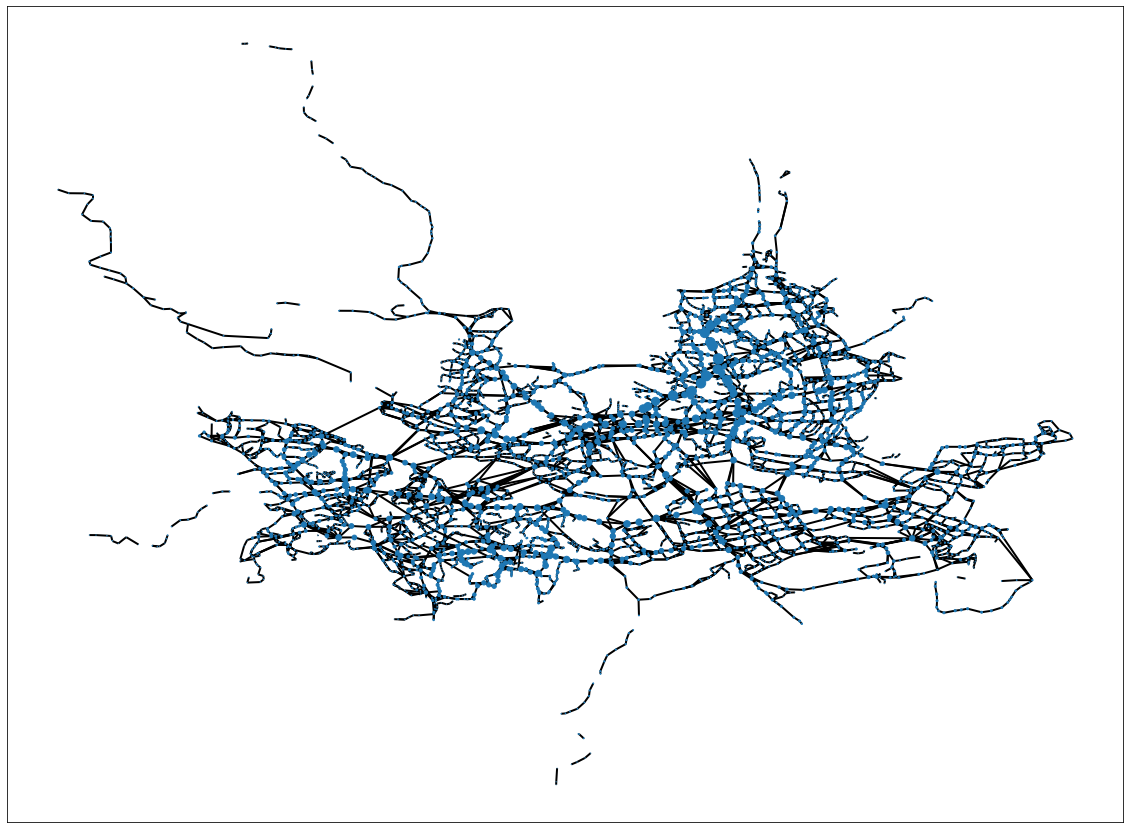

In [31]:
plt.figure(figsize=(20,15))
nx.draw_networkx_edges(G_bus, pos[0], width=2)
# nx.draw_networkx_labels(G_bus, pos[0], {j:j for i,j in enumerate(pos[0])}, alpha=0.5, font_family=font_name, font_size=12)
nx.draw_networkx_nodes(G_bus, pos[0], node_size=[v*0.05 for v in node_size[0].values()])
plt.show()

# 지하철 경로 그래프

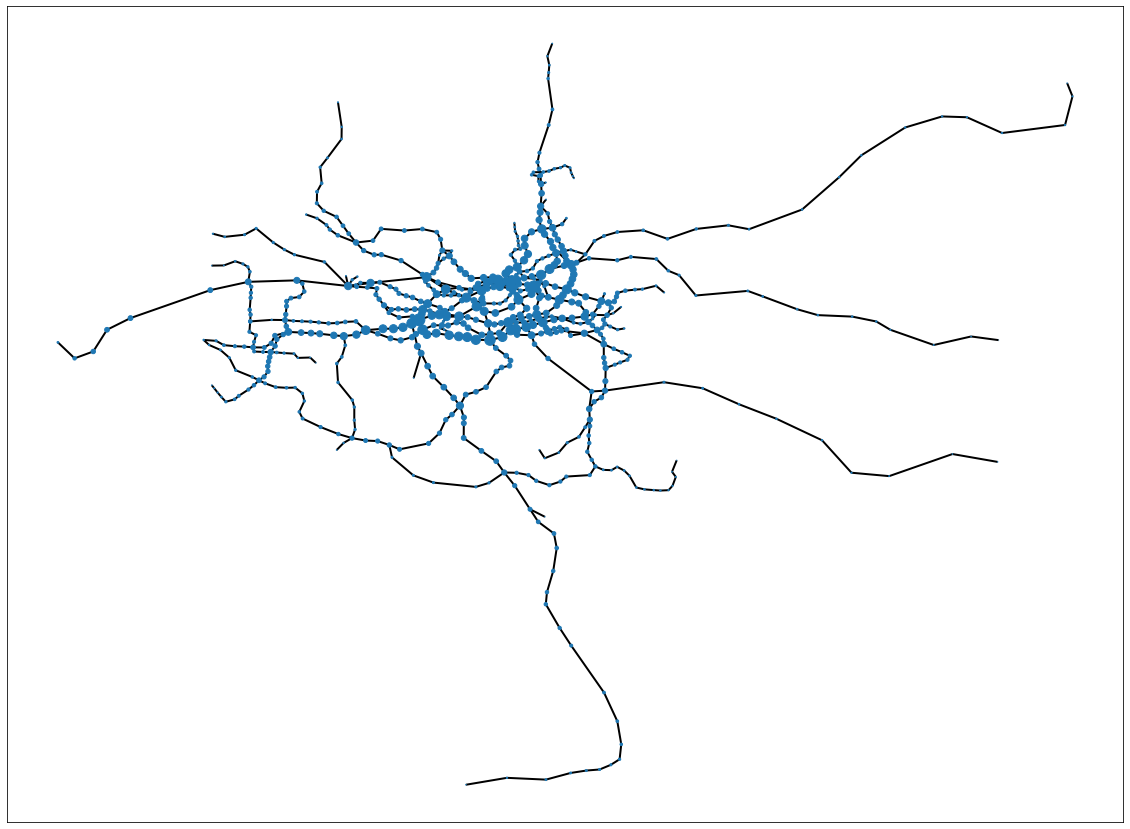

In [32]:
plt.figure(figsize=(20,15))
nx.draw_networkx_edges(G_metro, pos[1], width=2)
# nx.draw_networkx_labels(G_metro, pos[1], {j:j for i,j in enumerate(pos[1])}, alpha=0.5, font_family=font_name, font_size=15)
nx.draw_networkx_nodes(G_metro, pos[1], node_size=[v*0.015 for v in node_size[1].values()])
plt.show()

# multilayer 그래프

100%|████████████████████████████████████████████████████████████████████████████████████████| 599/599 [00:00<?, ?it/s]


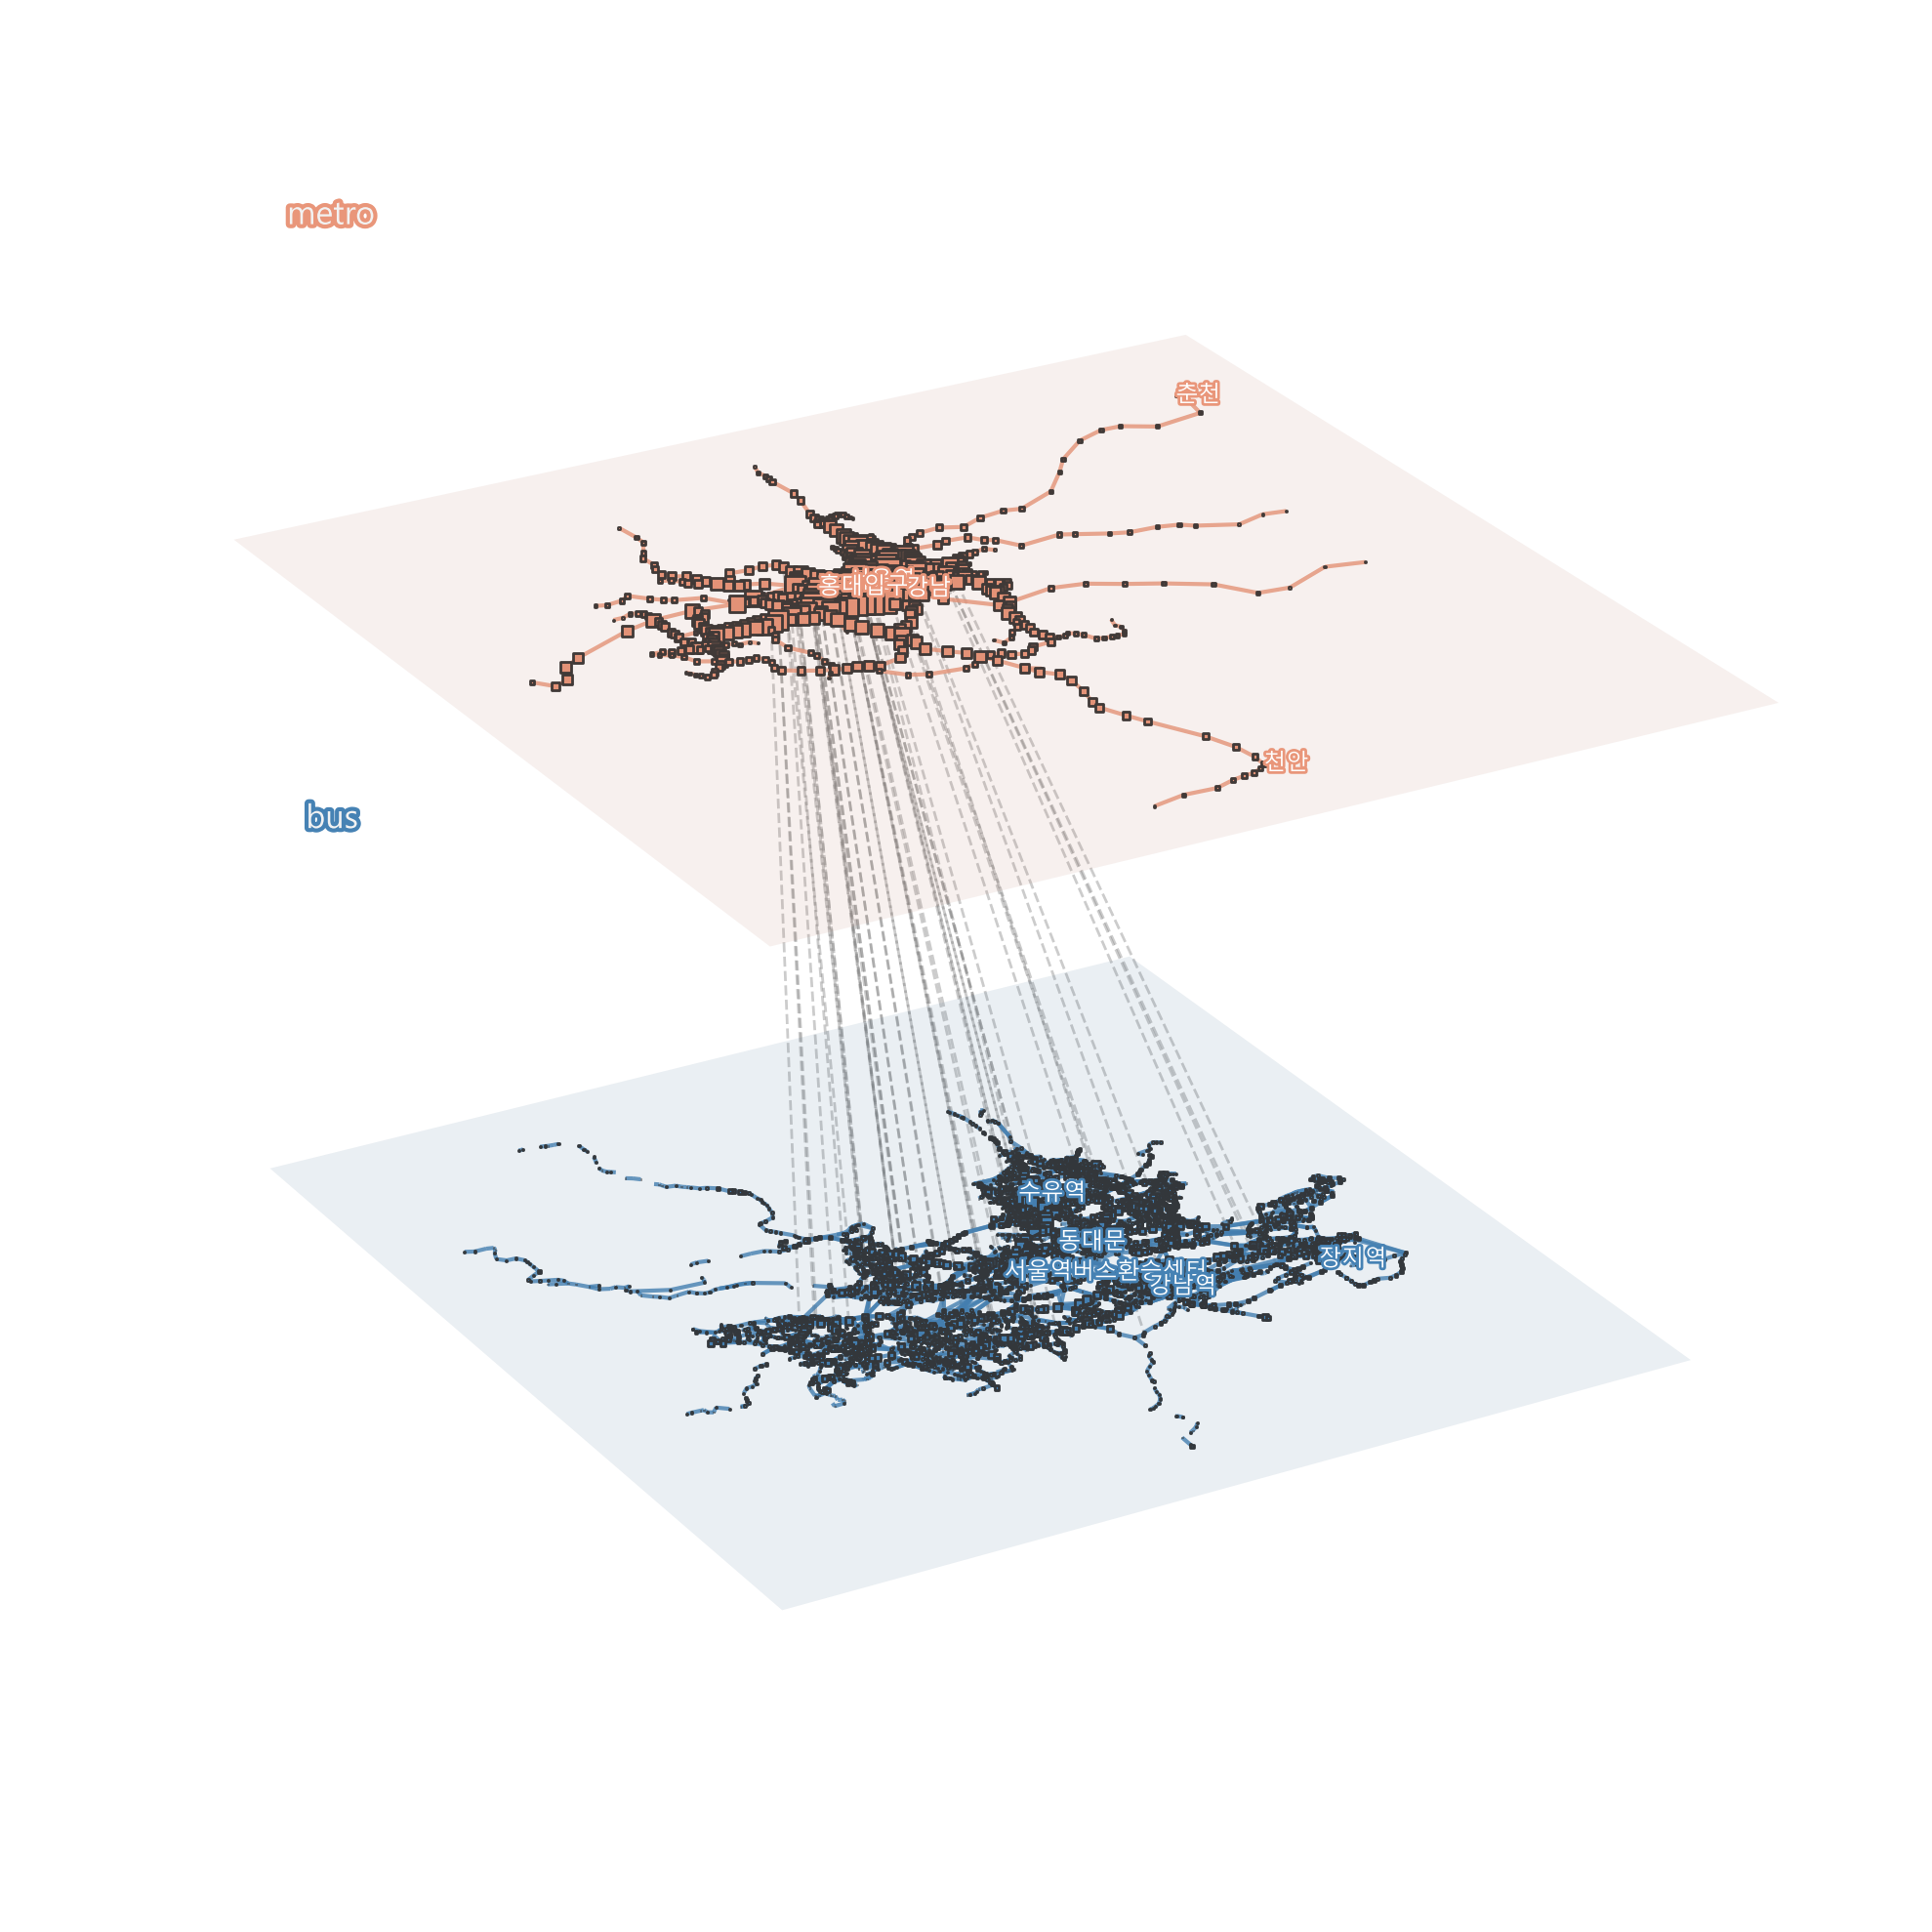

In [69]:
graphs = [G_bus, G_metro]
trans_labels = ['bus', 'metro']
cols = ['steelblue', 'darksalmon']
w = 10
h = 10
fig, ax = plt.subplots(1, 1, figsize=(w,h), dpi=200, subplot_kw={'projection':'3d'})
for gi, G in enumerate(graphs):
    xs = list(list(zip(*list(pos[gi].values())))[0])
    ys = list(list(zip(*list(pos[gi].values())))[1])
    zs = [gi]*len(xs)
    cs = [cols[gi]]*len(xs)
    lines3d_between = []
    if gi == 1:
        for i in tqdm(bm_path_df.values):
            if i[2]>20:
                t = []
                try:
                    buf = pos[0][i[0]].copy()
                    buf.append(0)
                    t.append(buf)
                    buf = pos[1][i[1]].copy()
                    buf.append(1)
                    t.append(buf)
                    lines3d_between.append(tuple(t))
                except:
                    pass
        for i in tqdm(mb_path_df.values):
            if i[2]>20:
                t = []
                try:
                    buf = pos[1][i[0]].copy()
                    buf.append(1)
                    t.append(buf)
                    buf = pos[0][i[1]].copy()
                    buf.append(0)
                    t.append(buf)
                    lines3d_between.append(tuple(t))
                except:
                    pass
    between_lines = Line3DCollection(lines3d_between, zorder=gi, color='.5', alpha=0.4, linestyle='--', linewidth=1)
    ax.add_collection3d(between_lines)
    lines3d = [(list(pos[gi][i])+[gi],list(pos[gi][j])+[gi]) for i,j in G.edges()]
    line_collection = Line3DCollection(lines3d, zorder=gi, color=cols[gi], alpha=0.8)
    ax.add_collection3d(line_collection)
    
    
    ax.scatter(xs, ys, zs, c=cs, edgecolors='.2', marker='s', alpha=1, zorder=gi+1, s=0.01*np.float64(list(node_size[gi].values())))

    
    for i in labels[gi]:
        buf = list(pos[gi].keys()).index(i)
        ax.text(xs[buf], ys[buf], zs[buf], i, color='1', fontsize='small', zorder=1e5, ha='left', va='center',
                    path_effects=[path_effects.Stroke(linewidth=2, foreground=cols[gi]),path_effects.Normal()])    
    
    
    
        
    xdiff = max(xs)-min(xs)
    ydiff = max(ys)-min(ys)
    ymin = min(ys)-ydiff*0.1
    ymax = max(ys)+ydiff*0.1
    xmin = min(xs)-xdiff*0.1 * (w/h)
    xmax = max(xs)+xdiff*0.1 * (w/h)
    xx, yy = np.meshgrid([xmin, xmax],[ymin, ymax])
    zz = np.zeros(xx.shape)+gi
    ax.plot_surface(xx, yy, zz, color=cols[gi], alpha=0.1, zorder=gi)

    layertext = ax.text(0.0, 1.15, gi*0.95+0.5, trans_labels[gi],
                        color='.95', fontsize='large', zorder=1e5, ha='left', va='center',
                        path_effects=[path_effects.Stroke(linewidth=3, foreground=cols[gi]),
                                      path_effects.Normal()])

ax.set_ylim(min(ys)-ydiff*0.1,max(ys)+ydiff*0.1)
ax.set_xlim(min(xs)-xdiff*0.1,max(xs)+xdiff*0.1)
ax.set_zlim(-0.1, len(graphs) - 1 + 0.1)

angle = 240
height_angle = 25
ax.view_init(height_angle, angle)
ax.dist = 10.5

ax.set_axis_off()
#plt.savefig('multilayer_network.png',dpi=425,bbox_inches='tight')
plt.tight_layout()
plt.show()

# 행정구역별

In [34]:
G_bus_zone = {i:nx.Graph() for i in bus_path_df_zone}
for i in G_bus_zone:
    for j in bus_path_df_zone[i].values:
        G_bus_zone[i].add_edge(j[0], j[1])
G_metro_zone = {i:nx.Graph() for i in metro_path_df_zone}
for i in G_metro_zone:
    for j in metro_path_df_zone[i].values:
        G_metro_zone[i].add_edge(j[0], j[1])

In [35]:
pos_zone = {}
for i in zone_list:
    buf = []
    t = {}
    for j in G_bus_zone[i].nodes():
        t[j] = pos[0][j]
    buf.append(t)
    t = {}
    for j in G_metro_zone[i].nodes():
        t[j] = pos[1][j]
    buf.append(t)
    pos_zone[i] = buf

In [36]:
for n in pos_zone:
    bufx = []
    bufy = []
    try:
        for i in pos_zone[n][0].keys():
            bufx.append(pos_zone[n][0][i][0])
            bufy.append(pos_zone[n][0][i][1])
        bufx = (bufx - np.float64(min(bufx))) / (max(bufx) - np.float64(min(bufx)))
        bufy = (bufy - np.float64(min(bufy))) / (max(bufy) - np.float64(min(bufy)))
    except:
        pass
    count = 0
    for i in pos_zone[n][0].keys():
        pos_zone[n][0][i] = [list(bufx)[count], list(bufy)[count]]
        count+=1


    bufx = []
    bufy = []
    try:
        for i in pos_zone[n][1].keys():
            bufx.append(pos_zone[n][1][i][0])
            bufy.append(pos_zone[n][1][i][1])
        bufx = (bufx - np.float64(min(bufx))) / (max(bufx) - np.float64(min(bufx)))
        bufy = (bufy - np.float64(min(bufy))) / (max(bufy) - np.float64(min(bufy)))
    except:
        pass
    count = 0
    for i in pos_zone[n][1].keys():
        pos_zone[n][1][i] = [list(bufx)[count], list(bufy)[count]]
        count+=1

In [37]:
node_size_zone = {}
for i in zone_list:
    buf = []
    t = {}
    for j in G_bus_zone[i].nodes():
        t[j] = node_size[0][j]
    buf.append(t)
    t = {}
    for j in G_metro_zone[i].nodes():
        t[j] = node_size[1][j]
    buf.append(t)
    node_size_zone[i] = buf

In [38]:
{i:j for i,j in enumerate(zone_list)}

{0: '강서구',
 1: '서초구',
 2: '구로구',
 3: '서대문구',
 4: '성북구',
 5: '강남구',
 6: '마포구',
 7: '강북구',
 8: '노원구',
 9: '영등포구',
 10: '동작구',
 11: '관악구',
 12: '도봉구',
 13: '은평구',
 14: '금천구',
 15: '성동구',
 16: '종로구',
 17: '중랑구',
 18: '양천구',
 19: '강동구',
 20: '송파구',
 21: '용산구',
 22: '광진구',
 23: '고양시 덕양구',
 24: '동대문구',
 25: '중구',
 26: '남양주시',
 27: '광명시',
 28: '파주시',
 29: '양주시',
 30: '고양시 일산서구',
 31: '성남시 분당구',
 32: '고양시 일산동구',
 33: '의정부시',
 34: '군포시',
 35: '성남시 수정구',
 36: '안양시 동안구',
 37: '성남시 중원구',
 38: '시흥시',
 39: '하남시',
 40: '구리시',
 41: '안양시 만안구',
 42: '부천시',
 43: '부천시 원미구',
 44: '용인시 기흥구',
 45: '과천시',
 46: '김포시',
 47: '의왕시',
 48: '부천시 오정구',
 49: '용인시 수지구',
 50: '서구',
 51: '남구',
 52: '부천시 소사구',
 53: '연수구',
 54: '남동구',
 55: '계양구',
 56: '양평군',
 57: '부평구'}

### n(0~57)값 변경으로 행정구역 그래프 변경

In [39]:
n = 20

### 버스

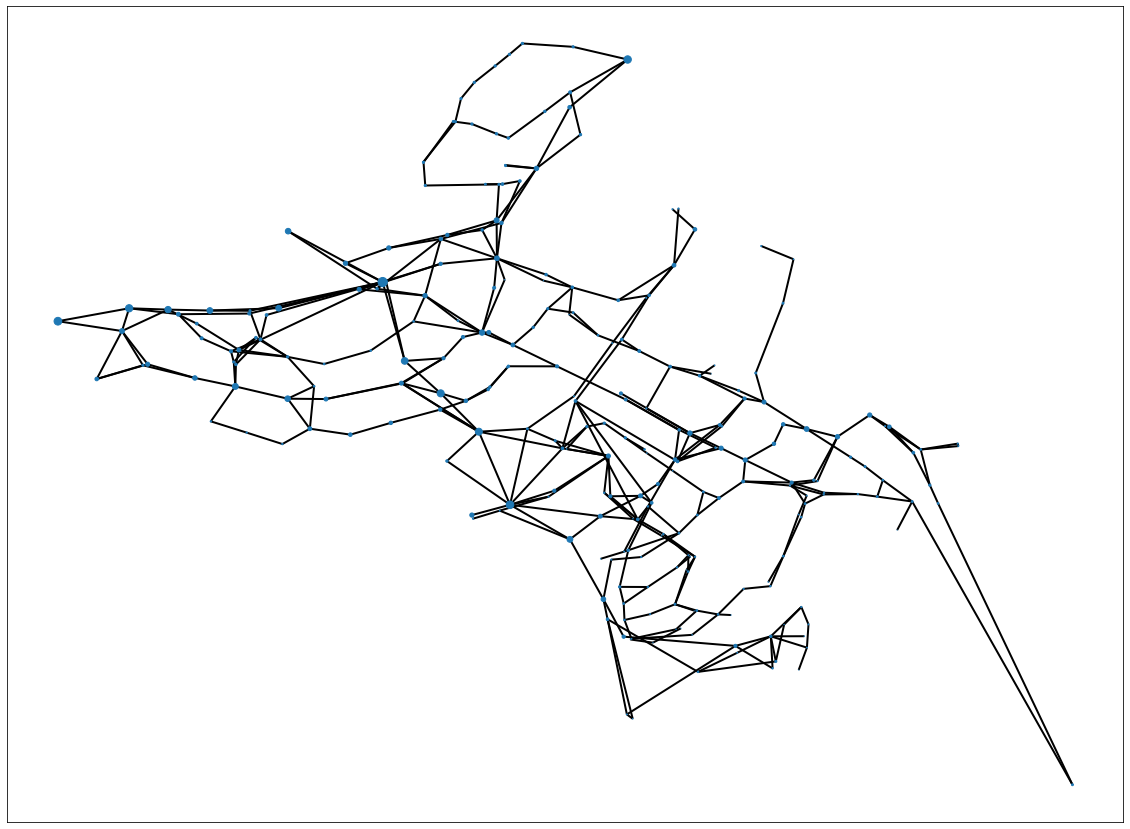

In [40]:
plt.figure(figsize=(20,15))
nx.draw_networkx_edges(G_bus_zone[zone_list[n]], pos[0], width=2)
# nx.draw_networkx_labels(G_bus_zone[zone_list[n]], pos[0], {j:j for i,j in enumerate(G_bus_zone[zone_list[n]].nodes())}, alpha=0.5, font_family=font_name, font_size=12)
nx.draw_networkx_nodes(G_bus_zone[zone_list[n]], pos[0], node_size=[v*0.1 for v in node_size_zone[zone_list[n]][0].values()])
plt.show()

### 지하철

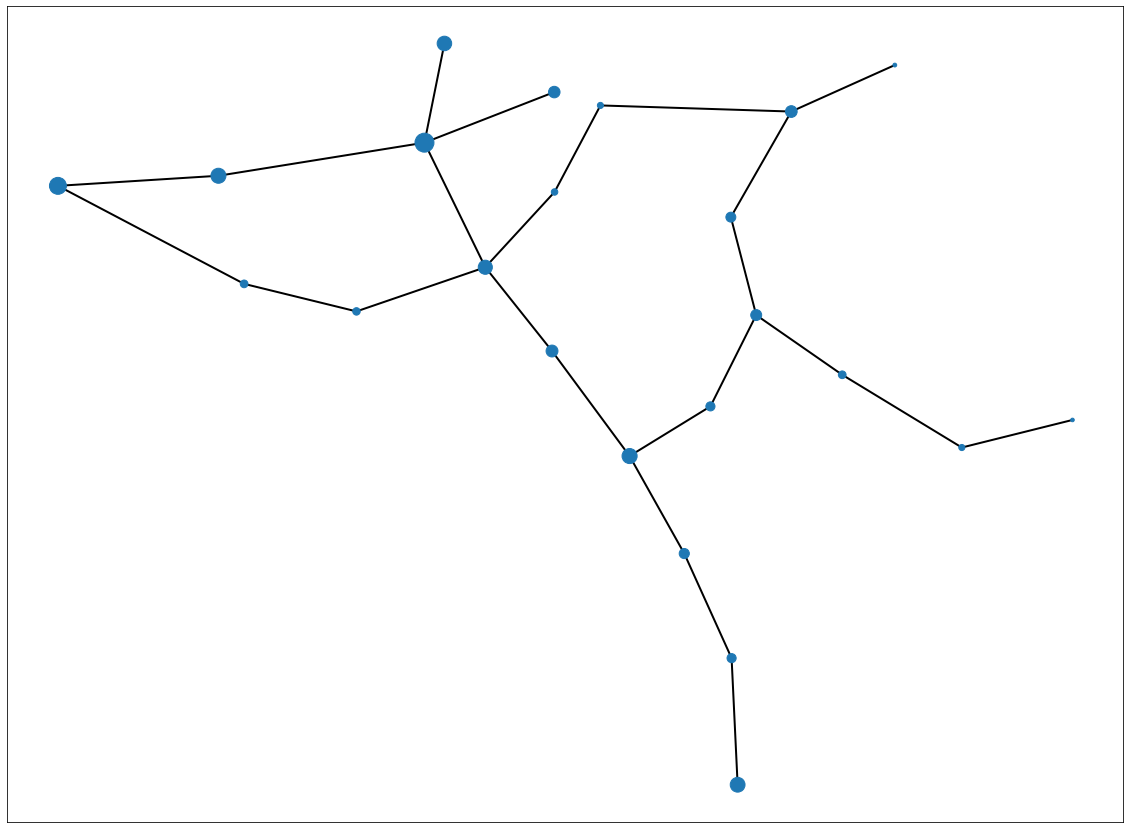

In [41]:
plt.figure(figsize=(20,15))
nx.draw_networkx_edges(G_metro_zone[zone_list[n]], pos[1], width=2)
# nx.draw_networkx_labels(G_metro_zone[zone_list[n]], pos[1], {j:j for i,j in enumerate(G_metro_zone[zone_list[n]].nodes())}, alpha=0.5, font_family=font_name, font_size=12)
nx.draw_networkx_nodes(G_metro_zone[zone_list[n]], pos[1], node_size=[v*0.1 for v in node_size_zone[zone_list[n]][1].values()])
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<?, ?it/s]


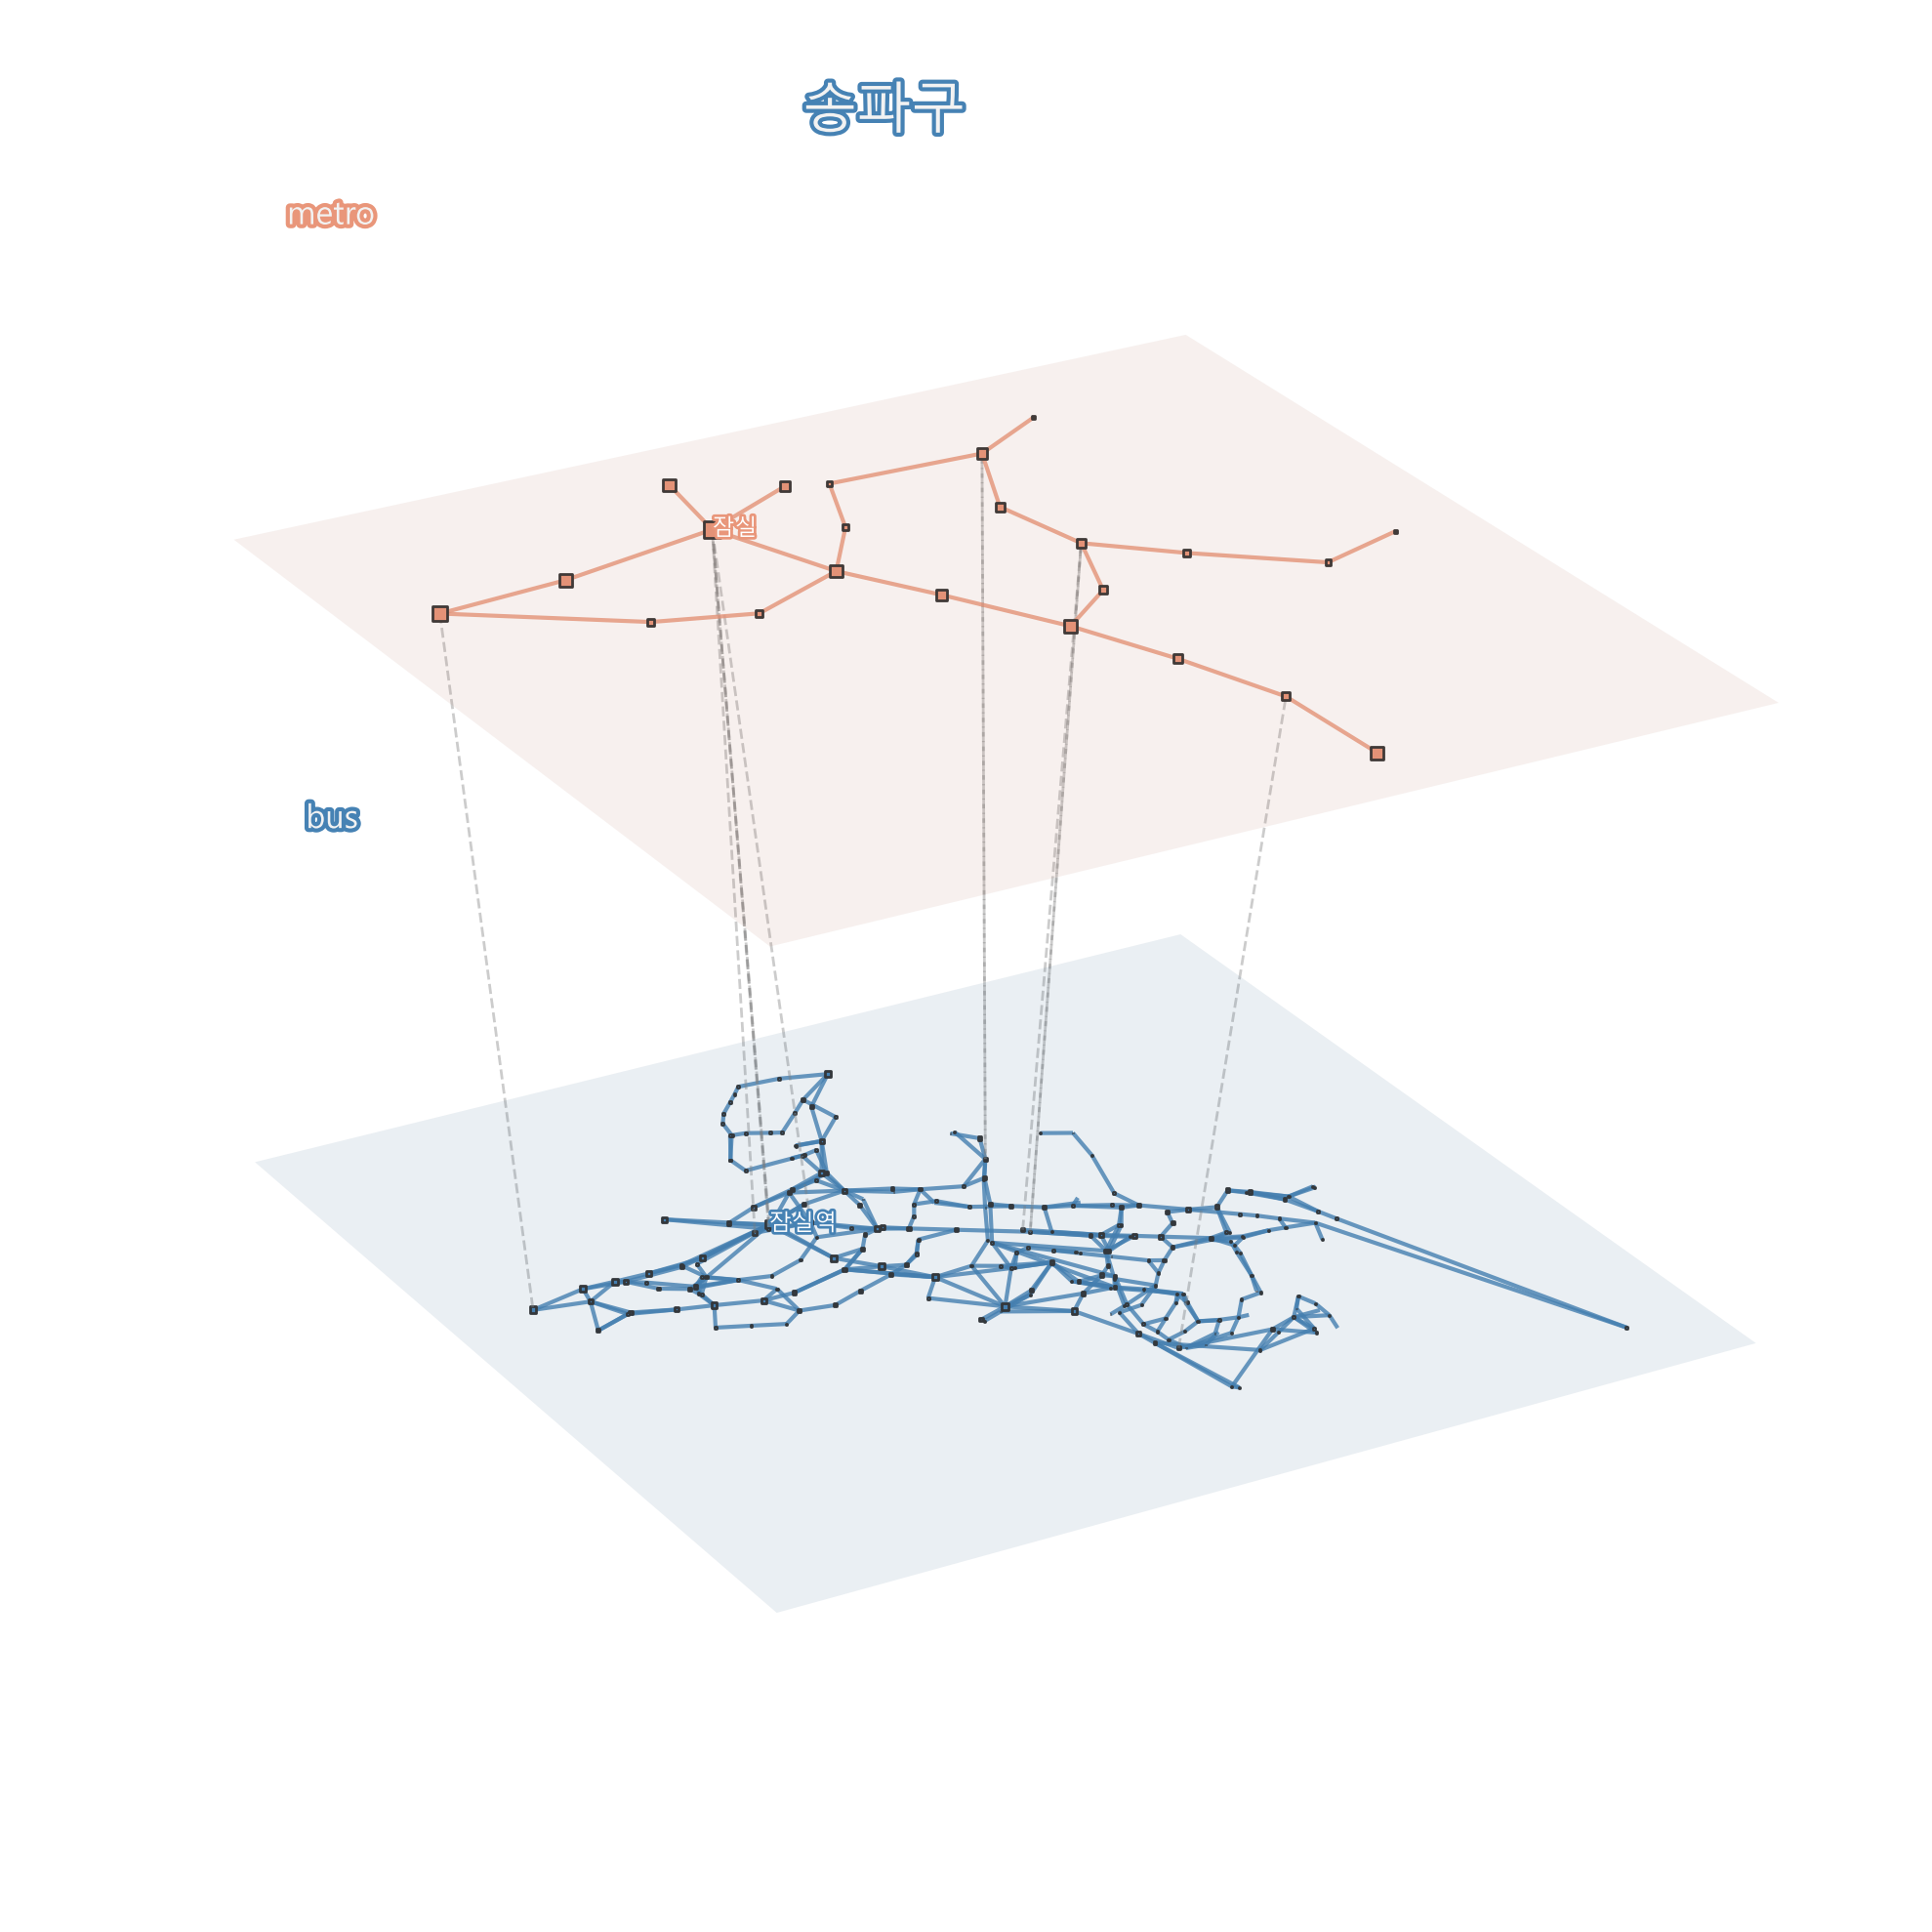

In [43]:
graphs = [G_bus_zone[zone_list[n]], G_metro_zone[zone_list[n]]]
trans_labels = ['bus', 'metro']
cols = ['steelblue', 'darksalmon']
w = 10
h = 10
fig, ax = plt.subplots(1, 1, figsize=(w,h), dpi=200, subplot_kw={'projection':'3d'})
for gi, G in enumerate(graphs):
    xs = list(list(zip(*list(pos_zone[zone_list[n]][gi].values())))[0])
    ys = list(list(zip(*list(pos_zone[zone_list[n]][gi].values())))[1])
    zs = [gi]*len(xs)
    cs = [cols[gi]]*len(xs)
    lines3d_between = []
    if gi == 1:
        for i in tqdm(bm_path_df_zone[zone_list[n]].values):
            if i[2]>5:
                t = []
                try:
                    buf = pos_zone[zone_list[n]][0][i[0]].copy()
                    buf.append(0)
                    t.append(buf)
                    buf = pos_zone[zone_list[n]][1][i[1]].copy()
                    buf.append(1)
                    t.append(buf)
                    lines3d_between.append(tuple(t))
                except:
                    pass
        for i in tqdm(mb_path_df_zone[zone_list[n]].values):
            if i[2]>5:
                t = []
                try:
                    buf = pos_zone[zone_list[n]][1][i[0]].copy()
                    buf.append(1)
                    t.append(buf)
                    buf = pos_zone[zone_list[n]][0][i[1]].copy()
                    buf.append(0)
                    t.append(buf)
                    lines3d_between.append(tuple(t))
                except:
                    pass
    between_lines = Line3DCollection(lines3d_between, zorder=gi, color='.5', alpha=0.4, linestyle='--', linewidth=1)
    ax.add_collection3d(between_lines)
    lines3d = [(list(pos_zone[zone_list[n]][gi][i])+[gi],list(pos_zone[zone_list[n]][gi][j])+[gi]) for i,j in G.edges()]
    line_collection = Line3DCollection(lines3d, zorder=gi, color=cols[gi], alpha=0.8)
    ax.add_collection3d(line_collection)
    ax.scatter(xs, ys, zs, c=cs, edgecolors='.2', marker='s', alpha=1, zorder=gi+1, s=0.01*np.float64(list(node_size_zone[zone_list[n]][gi].values())))
    
    t = [k for k,v in node_size_zone[zone_list[n]][gi].items() if max(node_size_zone[zone_list[n]][gi].values()) == v][0]
    buf = list(pos_zone[zone_list[n]][gi].keys()).index(t)
    ax.text(xs[buf], ys[buf], zs[buf], t, color='1', fontsize='small', zorder=1e5, ha='left', va='center',
                    path_effects=[path_effects.Stroke(linewidth=2, foreground=cols[gi]),path_effects.Normal()]) 
        
    xdiff = max(xs)-min(xs)
    ydiff = max(ys)-min(ys)
    ymin = min(ys)-ydiff*0.1
    ymax = max(ys)+ydiff*0.1
    xmin = min(xs)-xdiff*0.1 * (w/h)
    xmax = max(xs)+xdiff*0.1 * (w/h)
    xx, yy = np.meshgrid([xmin, xmax],[ymin, ymax])
    zz = np.zeros(xx.shape)+gi
    ax.plot_surface(xx, yy, zz, color=cols[gi], alpha=0.1, zorder=gi)

    if gi==0:
        layertext = ax.text(0.0, 0, 2.1, zone_list[n],
                        color='.95', fontsize=20, zorder=1e5, ha='left', va='center',
                        path_effects=[path_effects.Stroke(linewidth=3, foreground=cols[gi]),
                                      path_effects.Normal()])
    
    
    layertext = ax.text(0.0, 1.15, gi*0.95+0.5, trans_labels[gi],
                        color='.95', fontsize='large', zorder=1e5, ha='left', va='center',
                        path_effects=[path_effects.Stroke(linewidth=3, foreground=cols[gi]),
                                      path_effects.Normal()])
    
ax.set_ylim(min(ys)-ydiff*0.1,max(ys)+ydiff*0.1)
ax.set_xlim(min(xs)-xdiff*0.1,max(xs)+xdiff*0.1)
ax.set_zlim(-0.1, len(graphs) - 1 + 0.1)

angle = 240
height_angle = 25
ax.view_init(height_angle, angle)
ax.dist = 10.5

        


ax.set_axis_off()
#plt.savefig('multilayer_network.png',dpi=425,bbox_inches='tight')
plt.tight_layout()
plt.show()